## Extracting seasonal rainfall anomalies

This script takes as an input a `shapefile` with n number uniquely indentifiable polygons and exports a netcdf of per-pixel seasonal rainfall anomalies, and a csv of zonally averaged seasonal rainfall anomalies. Go to the `user inputs` section and enter the relevant information, then run the script.  The code is multiprocessed.



In [2]:
import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS
import fiona
import rasterio.mask
import rasterio.features
import xarray as xr
import os
import pandas as pd
import warnings
from multiprocessing import Pool

#need a datacube confing:
config = {
    'db_hostname': 'agdcdev-db.nci.org.au',
    'db_port': 6432,
    'db_database': 'dg6911'
}

dc = datacube.Datacube(config=config)

### User Inputs

In [ ]:
#path to shapefile
shp_path = "data/spatial/northern_basins.shp"
#time-range to extract from datacube
time_range = ('1990-06-01', '2019-02-28')
#Attribute column in the shapefile that identified the polygon
columnName = 'DNAME'
#projection the output should be in
projection = 'EPSG:3577'
#resolution of the output
resolution = (-750,750)
#where should the results be stored
output_dir = 'results/'
#how many cpus should the analysis run on?
ncpus = 1

### extract data and export to disk

In [ ]:
def RainfallFromShape(feat, crs, time_range, colummName, output_dir):
    
    first_geom = feat['geometry']
    poly_name = feat['properties'][columnName]
    geom = geometry.Geometry(first_geom, crs=crs)

    #generate query object
    query = {'geopolygon': geom}
    query['time'] = time_range
    query['output_crs'] = CRS(projection)
    query['resolution'] = resolution

    #get rainfall data
    print('Working on polygon: ' + poly_name)

    accum_prcp = dc.load(product='accum_prcp_monthly', **query)
    
    #using plygon to mask extracted rainfall data
    mask = rasterio.features.geometry_mask([geom.to_crs(accum_prcp.geobox.crs)for geoms in [geom]],
                                                   out_shape=accum_prcp.geobox.shape,
                                                   transform=accum_prcp.geobox.affine,
                                                   all_touched=False,
                                                   invert=False)

    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    accum_prcp = accum_prcp.where(mask_xr==False)

    #resample to quarterly,calclate climatology, calculate anoms
    prcp_quarterly = accum_prcp.resample(time='QS-JUN').sum('time')
    climatology_mean = prcp_quarterly.groupby('time.season').mean('time')
    climatology_std = prcp_quarterly.groupby('time.season').std('time')
    anomalies = prcp_quarterly.groupby('time.season') - climatology_mean
    standard_anom = xr.apply_ufunc(
                                lambda x, m, s: (x - m) / s,
                                prcp_quarterly.groupby('time.season'),
                                climatology_mean, climatology_std)
    
    #export
    anomalies.to_netcdf(output_dir + poly_name + "_rainfall_anomaly.nc")
    standard_anom.to_netcdf(output_dir + poly_name + "_rainfall_STDanomaly.nc")
    df = anomalies.accum_prcp.mean(['x', 'y']).to_pandas()
    df.to_csv(output_dir + poly_name + "_rainfall_anomaly.csv")


In [ ]:
with fiona.open(shp_path) as input:
    crs = geometry.CRS(input.crs_wkt)

In [ ]:
warnings.filterwarnings("ignore")
p = Pool(ncpus)
for feat in fiona.open(shp_path):
        RainfallFromShape(feat, crs, time_range, columnName, output_dir) # single-cpu
#     p.apply_async(RainfallFromShape, [feat, crs, time_range, columnName, output_dir]) # MULTIPROCESS

In [3]:
x = xr.open_dataarray('results/MURRAY-DARLING_rainfall_STDanomaly.nc')

In [ ]:
x.mean(['x', 'y']).mean()#plot(figsize=(15,4))

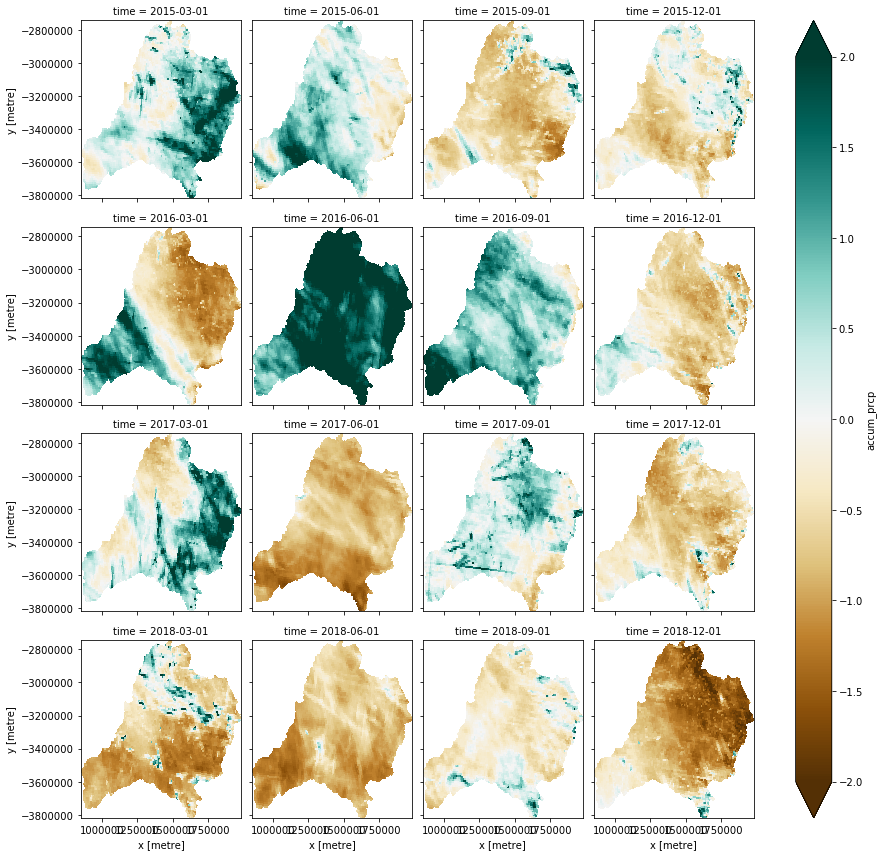

In [5]:
x.isel(time=range(99,115)).plot(col='time', col_wrap=4, cmap='BrBG', vmin=-2.0, vmax=2.0)

In [ ]:
#

In [ ]:
df = pd.read_csv('results/MURRAY-DARLING_rainfall_anomaly.csv', index_col=0, header=None, names=['season', 'rainfall'])

In [ ]:
df_winter = df[df.index.str.contains("06-01") | df.index.str.contains("09-01") | df.index.str.contains("03-01")]
df_winter.index = pd.to_datetime(df_winter.index)

In [ ]:
df_winter = df_winter.groupby(df_winter.index.year).sum()

In [ ]:
df_winter.to_csv('results/nmdb_winterRainAnoms.csv')

In [ ]:
df_winter.plot()

In [ ]:
df_winter